In [1]:
import jax
import jax.numpy as jnp
from ddpg_lstm import DDPG
from envs.KS_environment_jax import KSenv

from configs.enKF_config import get_config as get_config_exp
from configs.KS_config import get_config as get_config_env
from replay_buffer_jax import add_experience, init_replay_buffer, sample_sequences
from utils import covariance_matrix as cov

In [2]:
config = get_config_exp()
config.network.actor_n_hidden_state = 128
config.network.critic_n_hidden_state = 128
env_config = get_config_env()
config.env = env_config
# config.train.batch_size = 1
env = KSenv(**config.env)
agent = DDPG(config, env)

In [3]:
# Init PRNG
key = jax.random.PRNGKey(0)
key, key_network, key_buffer, key_env, key_obs, key_action = jax.random.split(
    key, 6
)

In [4]:
seq_len = 8

# Dummy data
dummy_obs_seq = jnp.zeros((config.train.batch_size, seq_len, env.num_observations))
dummy_action_seq = jnp.zeros((config.train.batch_size, seq_len, env.action_size))
dummy_reward_seq = jnp.zeros((config.train.batch_size, seq_len))
dummy_terminated_seq = jnp.zeros((config.train.batch_size, seq_len))

actor_state, critic_state = agent.initial_network_state(key_network, dummy_obs_seq, dummy_action_seq)

In [5]:
from functools import partial
# create some actual observations
env_reset = partial(
        KSenv.reset,
        N=env.N,
        B=env.ks_solver.B,
        lin=env.ks_solver.lin,
        ik=env.ks_solver.ik,
        dt=env.ks_solver.dt,
        initial_amplitude=env.initial_amplitude,
        action_size=env.action_size,
        burn_in=env.burn_in,
        observation_inds=env.observation_inds,
    )
env_reset = jax.jit(env_reset)
env_step = partial(
    KSenv.step,
    frame_skip=env.frame_skip,
    B=env.ks_solver.B,
    lin=env.ks_solver.lin,
    ik=env.ks_solver.ik,
    dt=env.ks_solver.dt,
    target=env.target,
    actuator_loss_weight=env.actuator_loss_weight,
    termination_threshold=env.termination_threshold,
    observation_inds=env.observation_inds,
)
env_step = jax.jit(env_step)
env_sample_action = partial(
    KSenv.sample_continuous_space,
    low=env.action_low,
    high=env.action_high,
    shape=(env.action_size,),
)
env_sample_action = jax.jit(env_sample_action)

# initialize buffer
replay_buffer = init_replay_buffer(
    capacity=config.replay_buffer.capacity,
    state_dim=(env.num_observations,),
    action_dim=(env.action_size,),
    rng_key=key_buffer,
)

get_cov = partial(cov.get_prop, std=config.enKF.std_obs)
def random_observe_and_forecast(
        true_state,
        true_obs,
        obs,
        wait_steps,
        episode_steps,
        key_obs,
        key_action,
        replay_buffer,
    ):
        def forecast_fun(carry, _):
            true_state, true_obs, action = carry

            # get the next observation and reward with this action
            true_state, true_obs, reward, terminated, _, _ = env_step(
                state=true_state, action=action
            )

            return (true_state, true_obs, action), (
                true_state,
                true_obs,
                action,
                reward,
                terminated,
            )

        def body_fun(carry, _):
            # observe
            # we got an observation
            true_state, true_obs, obs, key_obs, key_action, replay_buffer = carry

            # get action
            key_action, _ = jax.random.split(key_action)
            action = env_sample_action(key=key_action)

            # propagate environment with the given action
            (next_true_state, next_true_obs, action), (
                true_state_arr,
                true_obs_arr,
                action_arr,
                reward_arr,
                terminated_arr,
            ) = jax.lax.scan(
                forecast_fun,
                (true_state, true_obs, action),
                jnp.arange(wait_steps),
            )

            obs_cov = get_cov(y=true_obs)

            # add noise on the observation
            key_obs, _ = jax.random.split(key_obs)
            next_obs = jax.random.multivariate_normal(
                key_obs, next_true_obs, obs_cov, method="svd"
            )

            # add
            replay_buffer = add_experience(
                replay_buffer, obs, action, reward_arr[-1], next_obs, terminated_arr[-1]
            )
            return (
                next_true_state,
                next_true_obs,
                next_obs,
                key_obs,
                key_action,
                replay_buffer,
            ), (true_state_arr, true_obs_arr, next_obs, action_arr, reward_arr)

        n_loops = episode_steps // wait_steps
        (true_state, true_obs, obs, key_obs, key_action, replay_buffer), (
            true_state_arr,
            true_obs_arr,
            obs_arr,
            action_arr,
            reward_arr,
        ) = jax.lax.scan(
            body_fun,
            (true_state, true_obs, obs, key_obs, key_action, replay_buffer),
            jnp.arange(n_loops),
        )
        return (
            true_state,
            true_obs,
            obs,
            key_obs,
            key_action,
            true_state_arr,
            true_obs_arr,
            obs_arr,
            action_arr,
            reward_arr,
            replay_buffer,
        )

random_observe_and_forecast = partial(
        random_observe_and_forecast,
        wait_steps=config.enKF.wait_steps,
        episode_steps=config.episode_steps - config.enKF.observation_starts,
    )
random_observe_and_forecast = jax.jit(random_observe_and_forecast)

for _ in range(10):
    # reset the environment
    key_env, _, key_init = jax.random.split(key_env, 3)
    init_true_state, _, _ = env_reset(key=key_env)
    init_true_obs = init_true_state[env.observation_inds]

    # add noise on the observation
    obs_cov = get_cov(y=init_true_obs)
    key_obs, _ = jax.random.split(key_obs)
    first_obs = jax.random.multivariate_normal(
        key_obs, init_true_obs, obs_cov, method="svd"
    )
    
    (
        true_state,
        true_obs,
        obs,
        key_obs,
        key_action,
        true_state_arr,
        true_obs_arr,
        obs_arr,
        action_arr,
        reward_arr,
        replay_buffer,
    ) = random_observe_and_forecast(
    true_state=init_true_state,
    true_obs=init_true_obs,
    obs=first_obs,
    key_obs=key_obs,
    key_action=key_action,
    replay_buffer=replay_buffer,
    )


In [6]:
q_losses = []
policy_losses = []
for _ in range(10):
    (obs_seq, action_seq, next_obs_seq, reward_seq, terminated_seq), replay_buffer = sample_sequences(replay_buffer, 
                                                                                    batch_size=config.train.batch_size, 
                                                                                    seq_len=seq_len, 
                                                                                    episode_len=config.episode_steps)
    critic_state, q_loss = agent.update_critic(actor_state, 
                        critic_state, 
                        obs_seq, 
                        action_seq, 
                        next_obs_seq, 
                        reward_seq,
                        terminated_seq,
                        )
    
    actor_state, policy_loss = agent.update_actor(actor_state, 
                        critic_state, 
                        obs_seq, 
                        action_seq, 
                        )
    
    q_losses.append(q_loss)
    policy_losses.append(policy_loss)

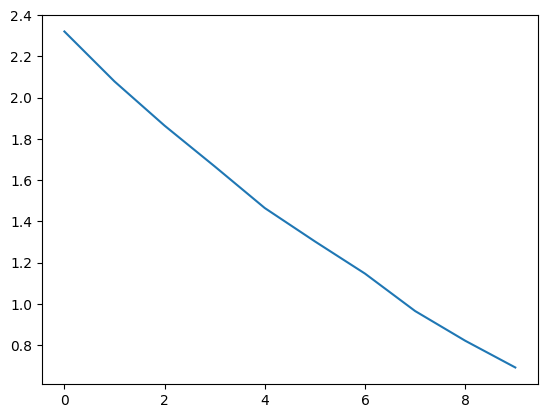

In [7]:
import matplotlib.pyplot as plt

plt.plot(q_losses)

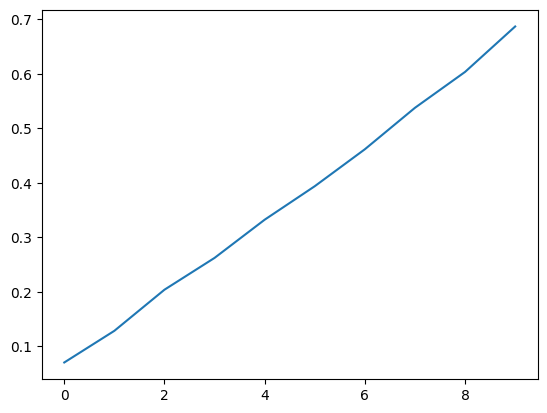

In [8]:
plt.plot(policy_losses)

In [11]:
obs = dummy_obs_seq[0][0]

In [12]:
obs

Array([0., 0., 0., 0.], dtype=float64)

In [22]:
lstm_carry = agent.initialise_actor_carry(batch_size=1)
action, next_lstm_carry = agent.actor.apply(actor_state.params, jnp.expand_dims(obs, axis=1), lstm_carry)

In [21]:
action.squeeze()

Array([[ 0.0192731 , -0.00732213,  0.01419498, -0.02127295,  0.01359643,
         0.01798492, -0.01876408, -0.00160507],
       [ 0.0192731 , -0.00732213,  0.01419498, -0.02127295,  0.01359643,
         0.01798492, -0.01876408, -0.00160507]], dtype=float64)